<a href="https://colab.research.google.com/github/jorgelum/EQ/blob/main/Monitoramento_Ar_ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: Jorge Luiz Mendes

Instituição: UNIFESP



## Introdução

O ozônio é um gás presente na atmosfera terrestre, que desempenha um papel importante na proteção contra a radiação ultravioleta. No entanto, em altas concentrações, o ozônio pode ser um poluente prejudicial à saúde humana e ao meio ambiente. (MARTINS, 2006)

As redes neurais artificiais (RNA) são um tipo de algoritmo de aprendizado de máquina que pode ser usado para prever a concentração de ozônio no ar. As RNA são inspiradas no sistema nervoso humano e são capazes de aprender representações não lineares de dados complexos.

As RNA têm sido usadas com sucesso para prever a concentração de ozônio em uma variedade de ambientes, incluindo cidades, regiões rurais e ambientes industriais.

## Objetivo


Meu objetivo é utilizar uma rede neural para prever a concentração de ozônio em uma determinada região do estado de São Paulo.



## Bibliotecas

In [ ]:
!pip install geobr
!pip install descartes

In [ ]:
import pandas as pd #tratamento de dados
import numpy as np #algebra linear
import datetime #tratamento de datas
import zipfile #arquivos zipados

import matplotlib.pyplot as plt #gráficos
import seaborn as sns #gráficos
import plotly.express as px #gráficos interativos
import geobr #mapas
import descartes #mapas

#redes neurais
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

## Dados

O os dados foram obtidos do Ministério do Meio Ambiente e Mudança do Clima ([MMA]('https://dados.mma.gov.br/dataset/ar-puro-monitorar')). Esse conjunto de dados faz parte do MonitorAr que é um aplicativo que fornece ao cidadão informações sobre a qualidade do Ar. O dicionário de dados se encontra nesse [link](https://dados.mma.gov.br/dataset/5be05b46-3bda-4f6e-9bf2-810e716fff33/resource/aa83d585-2064-4424-8324-d5da520a0470/download/dicionario_monitorar.pdf).

In [ ]:
!wget https://dados.mma.gov.br/dataset/5be05b46-3bda-4f6e-9bf2-810e716fff33/resource/937a288b-ce5e-40d9-a734-0650273c9992/download/monitor-ar_csv.zip

--2024-01-11 14:08:05--  https://dados.mma.gov.br/dataset/5be05b46-3bda-4f6e-9bf2-810e716fff33/resource/937a288b-ce5e-40d9-a734-0650273c9992/download/monitor-ar_csv.zip
Resolving dados.mma.gov.br (dados.mma.gov.br)... 45.231.205.6, 2801:80:2330:205::6
Connecting to dados.mma.gov.br (dados.mma.gov.br)|45.231.205.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20154242 (19M) [application/zip]
Saving to: ‘monitor-ar_csv.zip’

monitor-ar_csv.zip  100%[===================>]  19.22M   657KB/s    in 32s     

2024-01-11 14:08:38 (623 KB/s) - ‘monitor-ar_csv.zip’ saved [20154242/20154242]



In [ ]:
with zipfile.ZipFile("/content/monitor-ar_csv.zip") as f:
  for filename in f.namelist():
    print(filename)

Dados_monitorar_abr_jun_22-11-2022 DQAA.csv
Dados_monitorar_jan_mar_22-11-2022 DQAA.csv
Dados_monitorar_jul_nov_22-11-2022 DQAA.csv
Lista EstaçΣes MonitorAr - Nov-2022.csv


In [ ]:
lista_df = []
with zipfile.ZipFile("/content/monitor-ar_csv.zip") as f:
  for filename in f.namelist():
    with f.open(filename) as g:
       lista_df.append(pd.read_csv(g, encoding = 'latin-1',sep =';'))

In [ ]:
for lin,d in enumerate(lista_df):
  print(f'O {lin+1}º DataFrame: possui {d.shape[0]} linhas e {d.shape[1]} colunas')

O 1º DataFrame: possui 728275 linhas e 11 colunas
O 2º DataFrame: possui 733108 linhas e 11 colunas
O 3º DataFrame: possui 838850 linhas e 10 colunas
O 4º DataFrame: possui 154 linhas e 12 colunas


Selecionando os dados mais recentes.

In [ ]:
df = lista_df[2]
df.head()

,Nome do Município,Estado,Nome da Estação,Item_monitorado,Sigla,Concentracao,iqar,Data,Hora,Situação
0,Camaçari,BA,CÂMARA,Dióxido de Enxofre,SO2,0.891,3.4,22/11/2022,11:00,VA
1,Camaçari,BA,CÂMARA,Dióxido de Nitrogênio,NO2,5.670,5.12,22/11/2022,11:00,VA
2,Camaçari,BA,CÂMARA,Direção do vento,DV,116.732,NaN,22/11/2022,11:00,VA
3,Camaçari,BA,CÂMARA,Óxido Nítrico,NO,6.156,NaN,22/11/2022,11:00,VA
4,Camaçari,BA,CÂMARA,Óxidos de Nitrogênio,NOx,11.846,NaN,22/11/2022,11:00,VA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838850 entries, 0 to 838849
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Nome do Município  838850 non-null  object
 1   Estado             838850 non-null  object
 2   Nome da Estação    838850 non-null  object
 3   Item_monitorado    838850 non-null  object
 4   Sigla              838850 non-null  object
 5   Concentracao       838850 non-null  object
 6   iqar               471031 non-null  object
 7   Data               838850 non-null  object
 8   Hora               838850 non-null  object
 9   Situação           838850 non-null  object
dtypes: object(10)
memory usage: 64.0+ MB


## Região do ABC Paulista

Os dados cobrem o período de 01/07/2022 até 22/11/2022 e não há informações dos municípios de de Ribeirão Pires e Rio Grande da Serra.

In [ ]:
lista_Mun = ['santo andré','são bernardo do campo','são caetano do sul','diadema',
             'mauá']
df['Nome do Município'] = df['Nome do Município'].str.lower()
df_abc = df[(df['Estado']== 'SP') & (df['Nome do Município'].isin(lista_Mun))].reset_index(drop=True)
df_abc.head()

,Nome do Município,Estado,Nome da Estação,Item_monitorado,Sigla,Concentracao,iqar,Data,Hora,Situação
0,diadema,SP,Diadema,Ozônio,O3,10.000,10.0,22/11/2022,10:00,VA
1,mauá,SP,Mauá,Material Particulado com diâmetro de até 10 µm,MP10,29.000,29.0,22/11/2022,10:00,VA
2,santo andré,SP,S.André-Capuava,Material Particulado com diâmetro de até 10 µm,MP10,25.000,25.0,22/11/2022,10:00,VA
3,santo andré,SP,Santo Amaro,Material Particulado com diâmetro de até 10 µm,MP10,16.000,16.0,22/11/2022,10:00,VA
4,são bernardo do campo,SP,S.Bernardo-Centro,"Material Particulado com diâmetro de até 2,5 µm","MP2,5",25.000,25.0,22/11/2022,10:00,VA


Convertendo os dados para o formato correto.

In [ ]:
df_abc['Concentracao']=pd.to_numeric(df_abc['Concentracao'])
df_abc['Data']= pd.to_datetime(df_abc['Data'],format = '%d/%m/%Y')
df_abc['Dia'] = df_abc['Data'].dt.day
df_abc['mes'] = df_abc['Data'].dt.month
df_abc['hora'] = pd.to_datetime(df_abc['Hora'],format ='%H:%M')
df_abc['hora'] = df_abc['hora'].dt.hour

In [ ]:
df_abc.Sigla.value_counts()

MP10     9358
O3       7990
MP2,5    4464
SO2        26
CO         17
NO2         8
Name: Sigla, dtype: int64

Selecionando o item de monitoramento que será estudado.

In [ ]:
df_abc = df_abc[df_abc['Sigla']=='O3']
df_abc.head()

,Nome do Município,Estado,Nome da Estação,Item_monitorado,Sigla,Concentracao,iqar,Data,Hora,Situação,Dia,mes,hora
0,diadema,SP,Diadema,Ozônio,O3,10.0,10.0,2022-11-22,10:00,VA,22,11,10
6,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,09:00,VA,22,11,9
12,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,08:00,VA,22,11,8
18,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,07:00,VA,22,11,7
24,diadema,SP,Diadema,Ozônio,O3,9.0,9.0,2022-11-22,06:00,VA,22,11,6


### Análise Exploratória

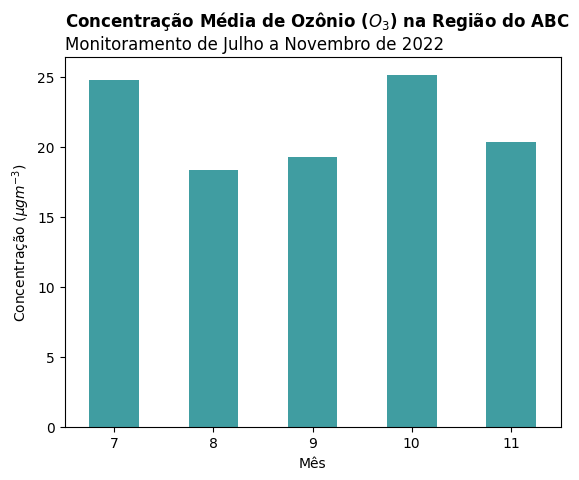

In [ ]:
(df_abc.groupby('mes')['Concentracao'].mean().round(2)
.plot(kind = 'bar',color = "#409da1"))
plt.xticks(rotation = 0)
plt.suptitle('Concentração Média de Ozônio ($O_{3}$) na Região do ABC',x =0.52,fontweight = 'bold')
plt.title('Monitoramento de Julho a Novembro de 2022', loc ='left')
plt.xlabel('Mês')
plt.ylabel('Concentração ($\mu g m^{-3}$)')

plt.show()

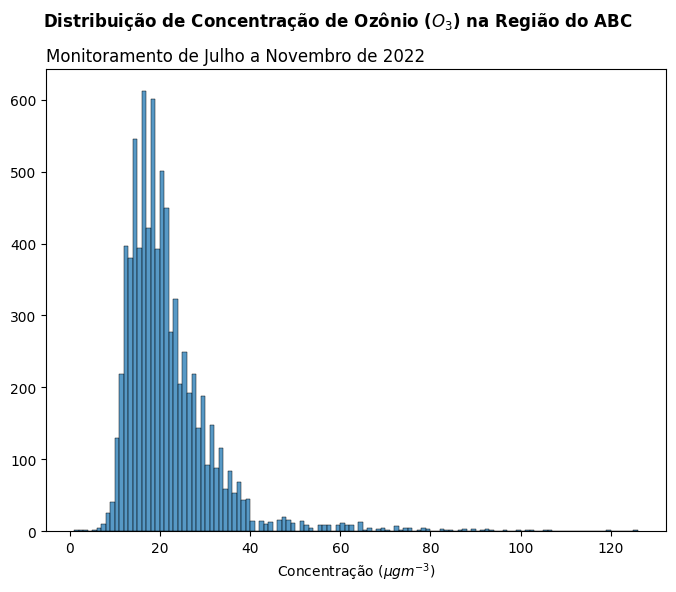

In [ ]:
plt.figure(figsize = (8,6))
sns.histplot(data = df_abc , x ='Concentracao')
plt.suptitle('Distribuição de Concentração de Ozônio ($O_{3}$) na Região do ABC',x =0.49,fontweight = 'bold')
plt.title('Monitoramento de Julho a Novembro de 2022', loc ='left')
plt.xlabel('Concentração ($\mu g m^{-3}$)')
plt.ylabel('')
plt.show()

In [ ]:
px.box(data_frame=df_abc ,y ='Concentracao',height= 450,width=600,title= "Boxplot da Concentração de Ozônio")

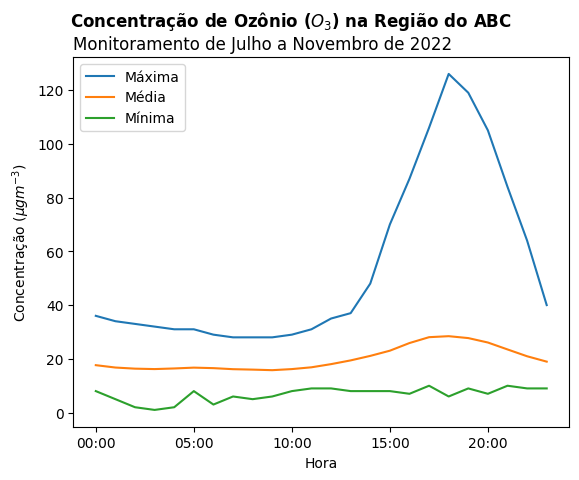

In [ ]:
df_abc.groupby('Hora')['Concentracao'].max().plot(kind = 'line',label = 'Máxima')
df_abc.groupby('Hora')['Concentracao'].mean().plot(kind = 'line',label = 'Média')
df_abc.groupby('Hora')['Concentracao'].min().plot(kind = 'line',label = 'Mínima')
plt.suptitle('Concentração de Ozônio ($O_{3}$) na Região do ABC',x =0.465,fontweight = 'bold')
plt.title('Monitoramento de Julho a Novembro de 2022', loc ='left')
plt.ylabel('Concentração ($\mu g m^{-3}$)')
plt.legend()
plt.show()

Podemos visualizar geograficamente os dados.

In [ ]:
mapa = geobr.read_municipality(code_muni= 35 ,year= 2018)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [ ]:
mapa['name_muni'] = mapa['name_muni'].str.lower()
mapa_abc = mapa[mapa['name_muni'].isin(lista_Mun)]
df_resumo = df_abc.groupby('Nome do Município')['Concentracao'].mean().reset_index()
df_completo = mapa_abc.merge(df_resumo, how = 'left',left_on='name_muni',right_on='Nome do Município')
df_completo.head()

,code_muni,name_muni,code_state,abbrev_state,geometry,Nome do Município,Concentracao
0,3513801.0,diadema,35.0,SP,"POLYGON ((-46.62653 -23.66163, -46.62598 -23.6...",diadema,20.800495
1,3529401.0,mauá,35.0,SP,"POLYGON ((-46.48227 -23.64936, -46.48149 -23.6...",mauá,20.458258
2,3547809.0,santo andré,35.0,SP,"POLYGON ((-46.49638 -23.62452, -46.49314 -23.6...",santo andré,20.897731
3,3548708.0,são bernardo do campo,35.0,SP,"POLYGON ((-46.53690 -23.69440, -46.53686 -23.6...",são bernardo do campo,22.555000
4,3548807.0,são caetano do sul,35.0,SP,"POLYGON ((-46.58239 -23.62200, -46.57900 -23.5...",são caetano do sul,21.820661


/usr/local/lib/python3.10/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



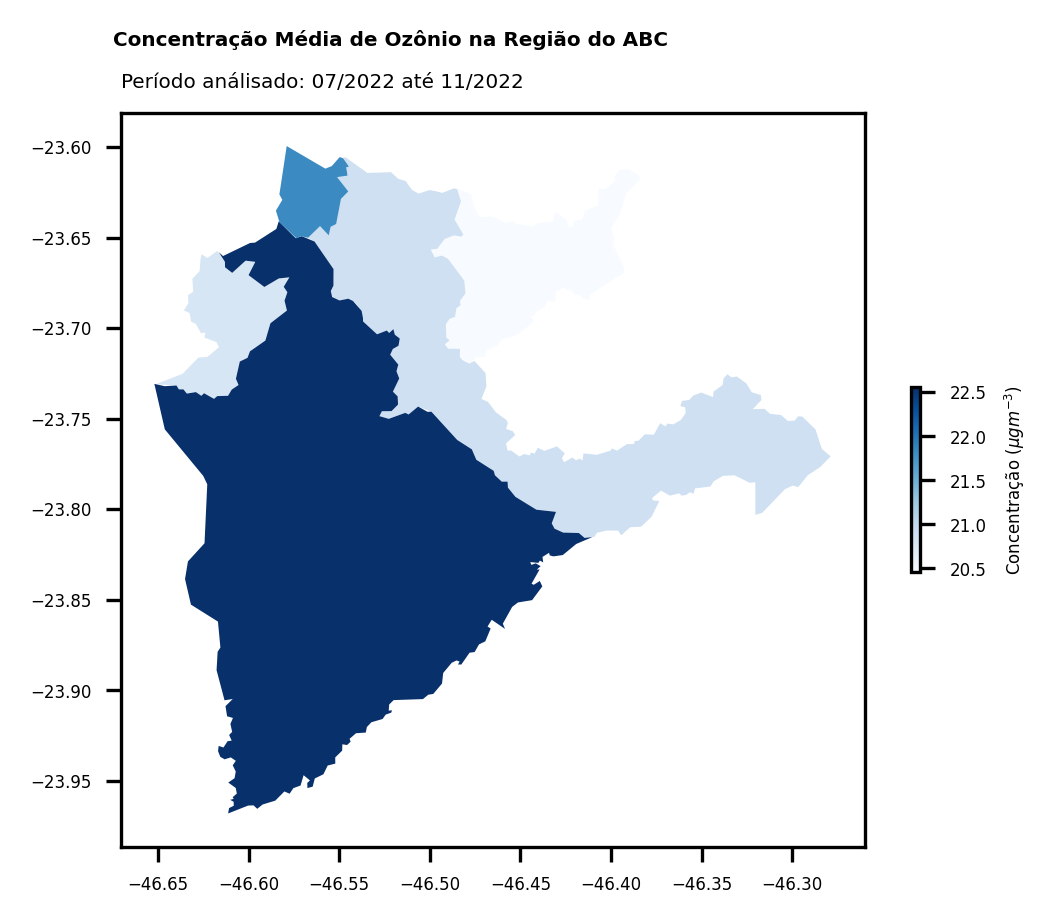

In [ ]:
plt.rcParams.update({"font.size": 4})

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
fig.suptitle("Concentração Média de Ozônio na Região do ABC",y =0.87,x =0.35,
             fontweight = 'bold')
df_completo.plot(
    column="Concentracao",
    cmap="Blues",
    legend=True,
    legend_kwds={
        "label": "Concentração ($\mu g m^{-3}$)",
        "orientation": "vertical",
        "shrink": 0.2,
    },
    ax=ax,
)


ax.set_title("Período análisado: 07/2022 até 11/2022", loc ='left')

plt.show()


## Modelagem

Quero que meu modelo diferencie as estações do ano.

0: Inverno e 1: Primavera

In [ ]:
data_ref = pd.to_datetime('2022-09-23')
df_abc['estacao'] = df_abc.Data.apply(lambda x: 0 if x < data_ref else 1)
df_abc.head()

,Nome do Município,Estado,Nome da Estação,Item_monitorado,Sigla,Concentracao,iqar,Data,Hora,Situação,Dia,mes,hora,estacao
0,diadema,SP,Diadema,Ozônio,O3,10.0,10.0,2022-11-22,10:00,VA,22,11,10,1
6,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,09:00,VA,22,11,9,1
12,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,08:00,VA,22,11,8,1
18,diadema,SP,Diadema,Ozônio,O3,8.0,8.0,2022-11-22,07:00,VA,22,11,7,1
24,diadema,SP,Diadema,Ozônio,O3,9.0,9.0,2022-11-22,06:00,VA,22,11,6,1


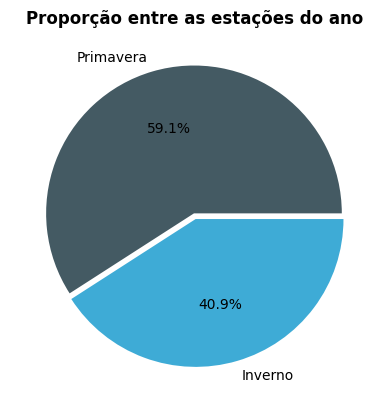

In [ ]:
plt.rcParams.update({"font.size": 10})
(df_abc.estacao.value_counts(normalize =True)
.plot(kind = 'pie', labels = ['Primavera','Inverno'],
      colors =['#445a63','#3eabd6'],
      autopct='%1.1f%%',explode=(0.02, 0.02)))
plt.title('Proporção entre as estações do ano',fontweight ='bold')
plt.ylabel('')
plt.show()

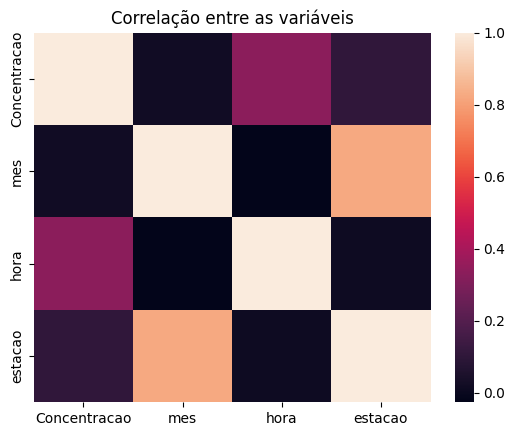

In [ ]:
df_abc_corr = df_abc[['Concentracao','mes','hora','estacao']].corr()
sns.heatmap(data = df_abc_corr)
plt.title('Correlação entre as variáveis')
plt.show()

Definindo as variáveis de entrada e de saída e separando os dados de treinamento e teste.

In [ ]:
features = ['Dia','hora','estacao']
target = 'Concentracao'
X = df_abc[features]
y = df_abc[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size= 0.7 ,random_state= 100)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Definindo a arquitetura da rede

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 8)  # Camada de entrada da rede neural com 3 entradas e 8 saídas
        self.fc2 = nn.Linear(8, 8) # Camada de oculta da rede neural com 8 entradas e 8 saídas
        self.fc3 = nn.Linear(8, 1) # Camada de entrada da rede neural 8 entradas e 1 saída


    def forward(self, x):
        x = torch.relu(self.fc1(x)) #funções de ativação
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Treinamento e Teste

In [ ]:
modelo = NeuralNetwork()

# Definir a função de perda e o otimizador
criterion = nn.MSELoss()  # Função de perda erro quadrático médio
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)  # Otimizador Ada com learning rate de 10^-3

# Treinamento da rede
Loss_ = []

num_epochs = 2000
for epoch in range(num_epochs):

    outputs = modelo(X_train_tensor)
    outputs = torch.squeeze(outputs)
    loss = criterion(outputs, y_train_tensor)
    Loss_.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 100 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Perda: {loss.item():.4f}')

# Avaliação
with torch.no_grad():
    modelo.eval()
    test_outputs = modelo(X_test_tensor)
    test_outputs = torch.squeeze(test_outputs)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Perda nos dados de teste: {test_loss.item():.4f}')

Época [100/2000], Perda: 311.0995
Época [200/2000], Perda: 118.0190
Época [300/2000], Perda: 107.6594
Época [400/2000], Perda: 104.2065
Época [500/2000], Perda: 102.9066
Época [600/2000], Perda: 102.0577
Época [700/2000], Perda: 101.2609
Época [800/2000], Perda: 100.4597
Época [900/2000], Perda: 99.6401
Época [1000/2000], Perda: 98.7697
Época [1100/2000], Perda: 97.8182
Época [1200/2000], Perda: 96.7681
Época [1300/2000], Perda: 95.5911
Época [1400/2000], Perda: 94.3194
Época [1500/2000], Perda: 93.0592
Época [1600/2000], Perda: 91.8656
Época [1700/2000], Perda: 90.7750
Época [1800/2000], Perda: 89.9849
Época [1900/2000], Perda: 89.4051
Época [2000/2000], Perda: 88.9576
Perda nos dados de teste: 82.4980


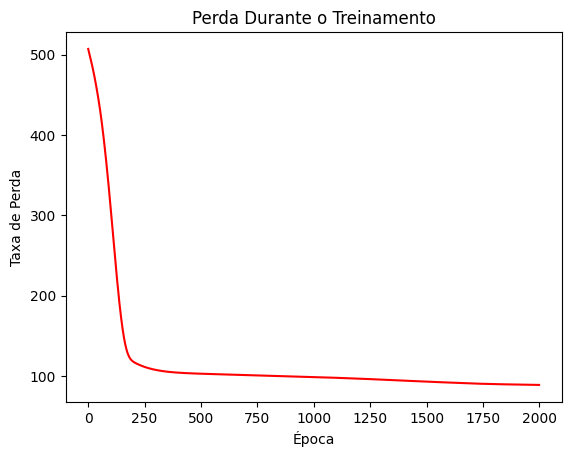

In [ ]:
plt.plot(range(2000),Loss_,color = 'red' )
plt.title('Perda Durante o Treinamento')
plt.ylabel('Taxa de Perda')
plt.xlabel('Época')
plt.show()

## Referências



MARTINS, L. D. Sensibilidade da Formação do Ozônio Troposférico às Emissões Veiculares
na  Região  Metropolitana  de  São  Paulo.  Tese  de  Doutorado.  Universidade  de  São  Paulo,
Instituto  de  Astronomia,  Geofísica  e  Ciências  Atmosféricas,  Departamento  de  Ciências
Atmosféricas. São Paulo, 2006.